# Neural network quantum process tomography (NN-QPT)

Let us generate a random quantum process using random unitaries as the Kraus
operators, $K_r$. The weights of the random unitaries are given by a geometric
series $w^0, w^1, w^2, ..., w^r$ where $r$ is the rank such that the channel
is formed by the normalized weights, $w_r$ and the terms $K_k$:

$$
\mathcal E \to \{w_k K_k\}
$$

In [113]:
import numpy as np


from qutip.random_objects import rand_unitary
from qutip import kraus_to_choi, Qobj, fidelity


import matplotlib.pyplot as plt
from matplotlib import colors


import jax
from jax import numpy as jnp
from jax import jit, vmap
import jax.config as config
config.update("jax_enable_x64", True)


import haiku as hk
import optax


from tqdm.auto import tqdm


np.random.seed(42)

In [114]:
num_qubits = 3
hilbert_size = 2**num_qubits
rank = 3


def random_chanel_geometric(N: int, r:int, weight: float = 1):
    """A random channel using random unitaries as Kraus terms and geometric 
    weights.

    Args:
        N (int): Hilbert space dimension
        r (int): Rank
        weight (float): Weight

    Returns:
        kraus_true (array): A r x N x N array of Kraus operators representing
                            the channel
    """
    weights_unnormalized = weight**np.arange(r)
    weights = weights_unnormalized / (weights_unnormalized).sum()
    kraus_true = np.array([np.sqrt(w)*rand_unitary(N, density=0.5) for w in weights])
    return kraus_true

kraus_true = random_chanel(hilbert_size, rank, 0.5)

### Converting to the Choi matrix and visualizing the process matrix

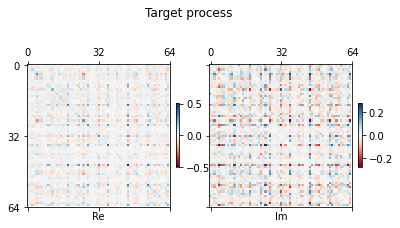

In [115]:
def plot_choi(choi, title="", cbar=False):
    """Plot the real and imaginary parts of the Choi matrix.

    Args:
        choi (np.array): The Choi matrix for the process.
        title (str, optional): The title for the plot.
        norm (colors.TwoSlopeNorm, optional): The normalization for the plot.
    """
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
    cmap = "RdBu"

    y = 0.95

    norm = colors.TwoSlopeNorm(vmin=-np.max(np.abs(choi.real)), vcenter=0, vmax=np.max(np.abs(choi.real)))
    im = ax[0].matshow(choi.real, cmap=cmap, norm=norm)
    norm = colors.TwoSlopeNorm(vmin=-np.max(np.abs(choi.imag)), vcenter=0, vmax=np.max(np.abs(choi.imag)))
    im2 = ax[1].matshow(choi.imag, cmap=cmap, norm=norm)

    if cbar is True:
        cbar_ax = plt.colorbar(im, ax=[ax[0]], fraction=0.021, pad=0.04)
        cbar_ax = plt.colorbar(im2, ax=[ax[1]], fraction=0.021, pad=0.04)

    ax[0].set_xlabel("Re")
    ax[1].set_xlabel("Im")
    ax[0].set_xticks([0, int(choi.shape[0]/2), choi.shape[0]])
    ax[0].set_yticks([0, int(choi.shape[0]/2), choi.shape[0]])
    ax[0].set_xticks([0, int(choi.shape[0]/2), choi.shape[0]])
    ax[0].set_yticks([0, int(choi.shape[0]/2), choi.shape[0]])

    plt.suptitle(title, y=y)


choi_true = kraus_to_choi([Qobj(kop) for kop in kraus_true])
plot_choi(choi_true.full(), title="Target process", cbar=True)

### Probes and measurements -- generate the data for reconstruction

We use the two eigenstates of the Pauli X, Y, Z operators as the probes and
measurements. There are 6 possibilities (X+, X-, Y+, Y-, Z+, Z-) and for $n$
qubits $6^n \times 6^n$ probes and measurements. These form our data after adding
random noise to the probability values.


We use the code implementation from the paper
[arXiv:2107.01060](https://arxiv.org/abs/2107.01060) to generate the Pauli
vectors and the measurement probabilities. The following code is taken from the
repository - [https://github.com/Hannoskaj/Hyperplane_Intersection_Projection](https://github.com/Hannoskaj/Hyperplane_Intersection_Projection)

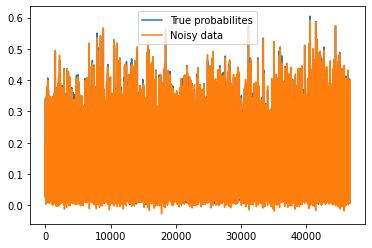

In [116]:
def probas_pauli(n, channel, optimize="optimal"):
    """Yields the probability of each Pauli measurement result for direct
    measurement method.
    
    For a given Pauli input state and measurement basis, sums to
    one. Hence total sum is $18^n$.

    Input: n is the number of qubits,
           channel are the nraus operators of the channel.
    Output array $(6^n, 6^n)$. First coordinate input state, second 
    coordinate measured output.

    Args:
        n (int): Number of qubits
        channel (np.ndarray): The channel represented by an (r, d, d) dim array
        optimize (str, optional): Einsum optimization strategy.
                                  Defaults to "optimal".

    Returns:
        res (np.ndarray): The probabilities for all combinations of Pauli input
                          states and measurements as a (6**n, 6**n) matrix.
    """
    res = 0
    Pk = prod_pauli_vecs(n)
    # Looping over kraus instead of doing everything in the einsum to
    # avoid excessive memory usage if the rank is high.
    for kraus in channel:
        a = np.einsum("nj, ij, mi -> nm", Pk, kraus, Pk.conj(), optimize="optimal")
        res += a.real ** 2 + a.imag ** 2
    return res

probas = probas_pauli(num_qubits, kraus_true)
data = probas + np.random.normal(0, 0.01, size=probas.shape)

plt.plot(probas.ravel(), label="True probabilites")
plt.plot(data.ravel(), label="Noisy data")
plt.legend()
plt.show()

### Making a predict function the works with arbitrary probes and measurements

We use the JAX vmap function to vectorize and JIT the predict function over
probes and measurements

In [117]:
@jit
def _predict(channel, op1,  op2):
    """Predicts the probabilities for Pauli measurements. 

    For a given Pauli input state and measurement basis, sums to
    one. Hence total sum is $18^k$.

    Output array $(6^k, 6^k)$. First coordinate input state, second 
    coordinate measured output.

    Args:
        channel (array): A list of Kraus operators representing the channel
        op1 (array): A single probe (Pauli vector)
        op2 (array): Measurement operator (also Pauli vector)

    Returns:
        res (float): Probability for selected probe and measurement.
    """
    res = 0.
    # Looping over kraus instead of doing everything in the einsum to
    # avoid excessive memory usage if the rank is high.
    for kraus in channel:
        # a = jnp.einsum("nj, ij, mi -> nm", op1, kraus, dag(op2), optimize="optimal")
        a = op1.T.conj()@kraus@op2
        res += (a.real**2 + a.imag**2) 
    return res


predict = jit(vmap(vmap(_predict, in_axes=[None, 0, None]), in_axes=[None, None, 0]))


def prod_pauli_vecs(n, U2=None):
    """Outputs all the n-tensor products of Pauli vectors, as an array where the
    vectors are the lines.

    Note:
    This implementation works till k=8. It needs $12^k$ complex entries.
    U2 allows to add a rotation to the Pauli vectors to avoid very special cases.

    TODO: There could be faster and more general way to do this.

    Args:
        n (int): The number of qubits.
        U2 (np.array, optional): A unitary of dimension 2**k. Defaults to None.

    Returns:
        [type]: [description]
    """
    s2 = np.sqrt(0.5)
    frame_vecs = np.array(
        ([1, 0], [0, 1], [s2, s2], [s2, -s2], [s2, s2 * 1j], [s2, -s2 * 1j])
    )
    if U2 is not None:
        frame_vecs = np.dot(frame_vecs, U2)
    einstein_indices = (
        "ai -> ai",
        "ai, bj -> abij",
        "ai, bj, ck -> abcijk",
        "ai, bj, ck, dl -> abcdijkl",
        "ai, bj, ck, dl, em -> abcdeijklm",
        "ai, bj, ck, dl, em, fn -> abcdefijklmn",
        "ai, bj, ck, dl, em, fn, go -> abcdefgijklmno",
        "ai, bj, ck, dl, em, fn, go, hp -> abcdefghijklmnop",
    )
    return np.einsum(einstein_indices[n - 1], *([frame_vecs] * n)).reshape(6 ** n, -1)

Pk = prod_pauli_vecs(num_qubits)
predicted = predict(kraus_true, Pk, Pk)

# Test out predictions give the non-noisy probabilities
np.testing.assert_array_almost_equal(probas, predicted)

### Neural network QPT

Let us make a simple neural network that outputs $k$ Kraus operators for a
($batchsize \times batchsize$) of input data. We use the deepmind-haiku library
to construct the network with JAX.

In [118]:
class Encoder(hk.Module):
    """Encoder model that goes from data -> Kraus_ops."""
    def __init__(self, hilbert_size, num_kraus=1):
        super().__init__()
        self.hilbert_size = hilbert_size
        self.num_kraus = num_kraus

    def __call__(self, x):
        x = hk.Flatten()(x)
        x = x.reshape(1, -1)

        x = hk.Linear(16)(x)
        x = jax.nn.softmax(x)

        x = hk.Linear(16)(x)
        x = jax.nn.softmax(x)

        x = hk.Linear(self.hilbert_size**2*self.num_kraus*2)(x)

        x = x.reshape(self.num_kraus, self.hilbert_size, self.hilbert_size, 2)
        x = jax.nn.tanh(x)
        
        k_ops = x.reshape(self.num_kraus, self.hilbert_size, self.hilbert_size, 2)
        
        return k_ops[..., 0] + 1j*k_ops[..., 1]

### Initialization of the forward function with a random batch of data

In [119]:
def generate_batch(batch_size, len_training):
    """Generates random indices to select a batch of the data 
       (probes x measurements)

    Args:
        batch_size (int): Batch size
        len_training (int): Length of training data 
                           (probes and measurements are assumed to be the same)

    Returns:
        idx : A meshgrid of indices for selecting the data.
        idx1, idx2 (array): Indices for the probes and measurements.
    """
    idx1, idx2 = np.random.randint(0, len_training, size=[2, batch_size])
    idx = tuple(np.meshgrid(idx1, idx2))
    return idx, idx1, idx2


num_kraus = 5 # 4**k
batch_size = 16

idx, idx1, idx2 = generate_batch(batch_size, data.shape[0])
model_forward = hk.transform(lambda x: Encoder(hilbert_size=hilbert_size,
                                               num_kraus=num_kraus)(x))

rng_seq = hk.PRNGSequence(32)
params = model_forward.init(next(rng_seq), data.T[idx].real)
print(hk.experimental.tabulate(model_forward)(data.T[idx].real))

+---------------------------+--------------------------------------+-----------------+------------+-------------+---------------+---------------+
| Module                    | Config                               | Module params   | Input      | Output      |   Param count |   Param bytes |
+===========================+======================================+=================+============+=============+===============+===============+
| encoder (Encoder)         | Encoder(hilbert_size=8, num_kraus=5) |                 | f64[16,16] | c128[5,8,8] |        15,264 |     122.11 KB |
+---------------------------+--------------------------------------+-----------------+------------+-------------+---------------+---------------+
| encoder/flatten (Flatten) | Flatten()                            |                 | f64[16,16] | f64[16,16]  |             0 |        0.00 B |
|  └ encoder (Encoder)      |                                      |                 |            |             |           

### What process operators does the network predict

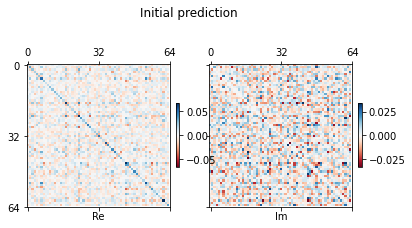

In [120]:
kraus_pred = np.array(model_forward.apply(params, next(rng_seq), data.T[idx].real))
choi_pred = kraus_to_choi([Qobj(kop) for kop in kraus_pred])
plot_choi(choi_pred.full(), title="Initial prediction", cbar=True)
plt.show()

### Is this a proper quantum process?

Note that the Kraus representation makes sure that the CP condition is met
but the TP condition is violated by the predicted Kraus operators

In [121]:
print(choi_pred.iscp, choi_pred.istp)

True False


### Training the network

We use the optimization tool optax to train.

100%|██████████| 1000/1000 [00:04<00:00, 228.01it/s]


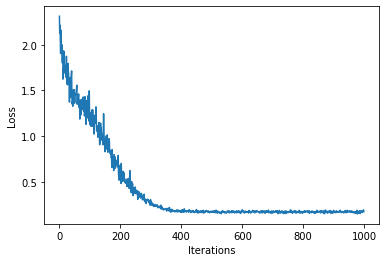

In [122]:
@jit
def dag(op: jnp.array)->jnp.array:
    """Dagger operation on an operator

    Args:
        op (jnp.array): Any operator to take the dagger operation on.

    Returns:
        jnp.array: Conjuage transpose of the operator.
    """
    return jnp.conjugate(jnp.transpose(op))

dag_vectorized = vmap(dag)


I = jnp.eye(2**num_qubits)
def trace_cost(operator):
    """
    Cost of keeping the trace (maybe) non-increasing.
    """
    opsum = jnp.einsum('mij, mjk -> ik', dag_vectorized(operator), operator)
    diff = jnp.sum(opsum - I)
    return diff.real**2


@jit
def loss_fn(params, rng, d_batch, probes, measurements):
    """Loss function for the trainnig.

    Args:
        params (_type_): Network parameters
        rng (_type_): Random number seq
        d_batch (_type_): A (batchsize x batchsize) input of probabilies
        probes (_type_): The probe operators. Note that these are assumed to be
                         Pauli vectors that the predict function knows how
                         to use.
        measurements (_type_): The measurement operators as Pauli vectors.

    Returns:
        loss (float): A scalar loss
    """
    k_ops = model_forward.apply(params, rng, d_batch)
    d_pred = predict(k_ops, probes, measurements)

    return (jnp.linalg.norm((d_batch - d_pred)) 
            + 0.01*trace_cost(k_ops) 
            + 0.01*jnp.mean(jnp.abs(k_ops)))


@jax.jit
def update(rng, params, opt_state, d_batch, probes, measurements):
    """Single SGD update step."""
    grads = jax.grad(loss_fn, argnums=0)(params, rng, d_batch, probes, measurements)
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state



optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)
loss_hist = []
params_hist = []


for step in tqdm(range(1000)):
    idx, idx1, idx2 = generate_batch(batch_size, data.shape[0])
    params, opt_state = update(next(rng_seq), params, opt_state, data.T[idx].real, Pk[idx1], Pk[idx2])
    params_hist.append(params)

    idx, idx1, idx2 = generate_batch(batch_size, data.shape[0])
    loss_hist.append(loss_fn(params, next(rng_seq), data.T[idx].real, Pk[idx1], Pk[idx2]))

plt.plot(loss_hist)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

# Predictions

We can predict using any random batch of data. 


/Users/shahnawaz/miniconda3/envs/jaxnn/lib/python3.9/site-packages/qutip/qobj.py:551: UserWarning: Multiplying superoperators with different representations
  warnings.warn(msg)


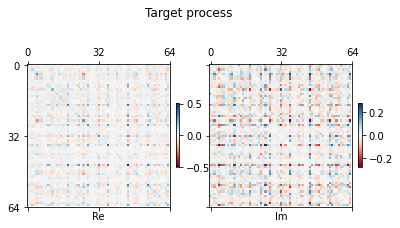

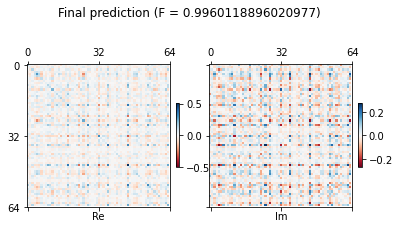

In [123]:
idx, idx1, idx2 = generate_batch(batch_size, data.shape[0])
kraus_pred = np.array(model_forward.apply(params, next(rng_seq), data.T[idx].real))
choi_pred = kraus_to_choi([Qobj(kop) for kop in kraus_pred])
fidel = fidelity(choi_pred/2**num_qubits, choi_true/2**num_qubits)


plot_choi(choi_true.full(), title="Target process", cbar=True)
plt.show()

plot_choi(choi_pred.full(), title="Final prediction (F = {})".format(fidel), cbar=True)
plt.show()